# MVP

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# AWS Libraries
import logging
import boto3
from botocore.exceptions import ClientError

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Geo-mapping Libraries
import geopandas
import geopy
import folium 

# Helper Functions
import MVP_acquire_ds, MVP_explore

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

### Download the JSON Files from AWS S3 Bucket

In [2]:
# Create the s3 resource object
s3 = boto3.resource('s3')

# Download the json files from AWS

s3.Bucket("dspreparedjobpostings").download_file("df_ds_tx_prepared_backup.json", 
                                                 "df_ds_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of data scientist positions in TX
print("Last modified datetime for data scientist positions in TX: ", 
      s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json').last_modified)

s3.Bucket("wdpreparedjobpostings").download_file("df_wd_tx_prepared_backup.json", 
                                                 "df_wd_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of web developer positions in TX
print("Last modified datetime for web developer positions in TX: ", 
      s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json').last_modified)

Last modified datetime for data scientist positions in TX:  2021-03-01 02:40:44+00:00
Last modified datetime for web developer positions in TX:  2021-03-01 02:43:47+00:00


## Data Preparation

### Load JSON Files into Dataframe and Set the Date as the Index

In [3]:
# Read the json file and convert it to pandas dataframe

df_ds = pd.read_json('df_ds_tx_prepared_backup.json')
df_wd = pd.read_json('df_wd_tx_prepared_backup.json')

# Set the date column as the index and sort the index

df_ds.date = pd.to_datetime(df_ds.date)
df_ds = df_ds.set_index('date').sort_index(ascending=False)
df_wd.date = pd.to_datetime(df_wd.date)
df_wd = df_wd.set_index('date').sort_index(ascending=False)

# Print the number of job postings in each dataframe

print("Number of data scientist job postings in TX: ", df_ds.shape[0])
print("Number of web developer job postings in TX: ", df_wd.shape[0])

Number of data scientist job postings in TX:  2415
Number of web developer job postings in TX:  4692


In [4]:
# Print the concise summary of the dataframe df_ds
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2415 entries, 2021-02-28 to 2020-12-22
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            2415 non-null   object 
 1   company          2415 non-null   object 
 2   company_rating   2415 non-null   float64
 3   job_link         2415 non-null   object 
 4   job_description  2415 non-null   object 
 5   city             2415 non-null   object 
 6   state            2415 non-null   object 
 7   zipcode          2415 non-null   int64  
 8   clean            2415 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 188.7+ KB


In [5]:
# Print the concise summary of the dataframe df_wd
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4692 entries, 2021-02-28 to 2021-01-04
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4692 non-null   object 
 1   company          4692 non-null   object 
 2   company_rating   4692 non-null   float64
 3   job_link         4692 non-null   object 
 4   job_description  4692 non-null   object 
 5   city             4692 non-null   object 
 6   state            4692 non-null   object 
 7   zipcode          4692 non-null   int64  
 8   clean            4692 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 366.6+ KB


In [6]:
# Print the first 5 rows of the dataframe df_ds
df_ds.head()

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-02-28,Data Scientist,Nomi Health,0.0,https://www.indeed.com/rc/clk?jk=b688ed1680287...,WHO ARE WE?\nThe way we pay for healthcare in ...,Austin,TX,73301,way pay healthcare america today fundamentally...
2021-02-28,Strategy & Finance Data Scientist - Sr. Associate,"JPMorgan Chase Bank, N.A.",3.9,https://www.indeed.com/rc/clk?jk=40d81cdeef55a...,The Position:\nThis Strategy & Finance Data Sc...,Plano,TX,0,position strategy finance data scientist sr as...
2021-02-28,"Recruiting Manager, Machine Learning & Artific...",Facebook,4.2,https://www.indeed.com/rc/clk?jk=4e5fa0e6eae13...,Facebook is hiring some of the best technical ...,Austin,TX,0,facebook hiring best technical mind around nee...
2021-02-27,Senior Data Scientist,Real Estate Technology Start-up,0.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,We are seeking a part-time Data Scientist to j...,Austin,TX,0,seeking parttime data scientist join real esta...
2021-02-27,Data Scientist,Robert Half,3.9,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"As a Sr. Data Scientist, you will use your pla...",Houston,TX,77079,sr data scientist use platform leadership tech...


In [7]:
# Print the first 5 rows of the dataframe df_wd
df_wd.head()

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-02-28,Software Engineering-Front End Developer,"JPMorgan Chase Bank, N.A.",3.9,https://www.indeed.com/rc/clk?jk=fec0a2416cbed...,"As a member of our Software Engineering Group,...",Plano,TX,0,member software engineering group look first f...
2021-02-28,Website Application Developer,Baylor College of Medicine,3.9,https://www.indeed.com/rc/clk?jk=5f898ae405d51...,Summary\nJob Purpose\nWe are seeking an advanc...,Houston,TX,77030,summary job purpose seeking advanced drupal de...
2021-02-28,Full Stack Software Engineer - C#/.NET,"JPMorgan Chase Bank, N.A.",3.9,https://www.indeed.com/rc/clk?jk=23e344bde91e7...,"As a member of our Software Engineering Group,...",Plano,TX,0,member software engineering group look first f...
2021-02-28,Senior Full Stack Software Engineer,Fannie Mae,4.0,https://www.indeed.com/rc/clk?jk=c11d703c057f9...,": At Fannie Mae, futures are made. The inspiri...",Plano,TX,0,fannie mae future made inspiring work make aff...
2021-02-28,Sr. Java/React Software Engineer,"JPMorgan Chase Bank, N.A.",3.9,https://www.indeed.com/rc/clk?jk=e98b95096db51...,"Located in the heart of Houston City Center, w...",Houston,TX,0,located heart houston city center one six glob...


### Brief Summary of the Job Postings

#### Data Scientist Position

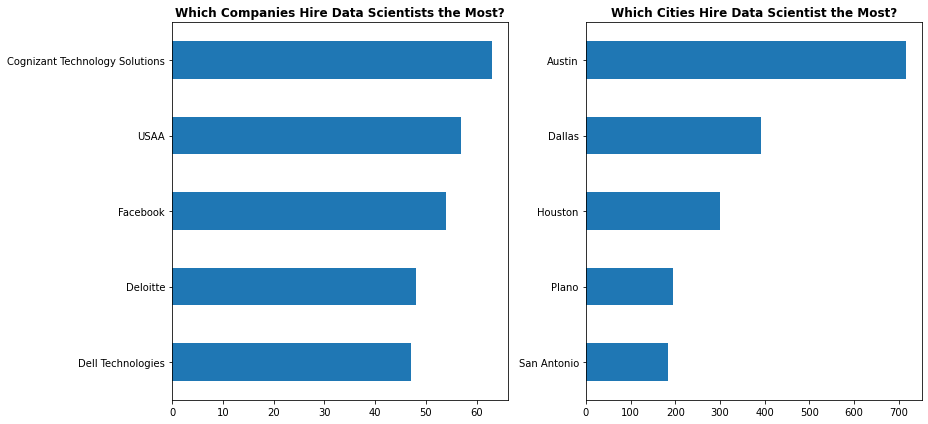

In [8]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_ds.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Data Scientists the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_ds.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Data Scientist the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# How does the number of job postings change over time?
df_ds.resample('W').title.count()

date
2020-12-27    392
2021-01-03    136
2021-01-10    212
2021-01-17    187
2021-01-24    352
2021-01-31    295
2021-02-07    265
2021-02-14    284
2021-02-21    166
2021-02-28    126
Freq: W-SUN, Name: title, dtype: int64

In [10]:
# Which company has the best avereage rating? 
df_ds.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Digital Pharmacist    5.0
Rekruiters            5.0
Onit                  4.7
Levelset              4.7
Harnham               4.6
Name: company_rating, dtype: float64

In [11]:
df_ds.title.value_counts().head()

Data Scientist               251
Senior Data Scientist         88
Senior Data Analyst           55
Machine Learning Engineer     53
Principal Data Scientist      40
Name: title, dtype: int64

#### Web Developer Position

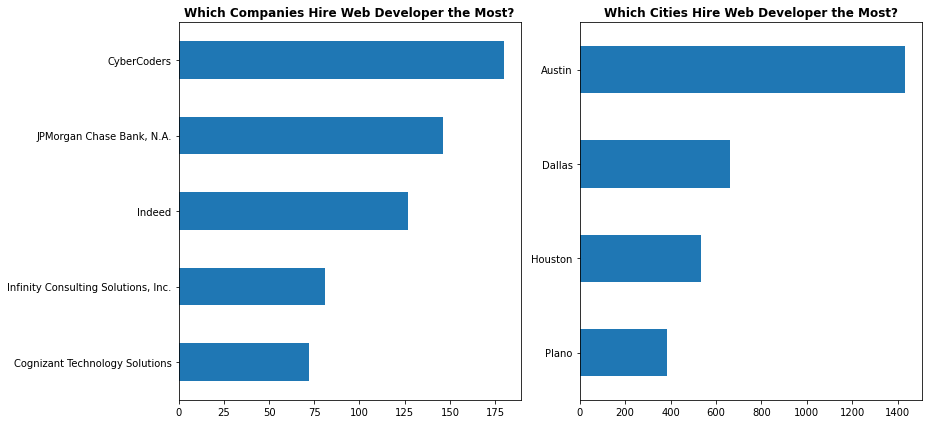

In [12]:
# Barplot the top 5 companies and top 4 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_wd.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Web Developer the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_wd.city.value_counts().head(4)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Web Developer the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# How does the number of job postings change over time?
df_wd.resample('W').title.count()

date
2021-01-10      62
2021-01-17     346
2021-01-24     793
2021-01-31    1054
2021-02-07     825
2021-02-14     786
2021-02-21     431
2021-02-28     395
Freq: W-SUN, Name: title, dtype: int64

In [14]:
# Which company has the best avereage rating? 
df_wd.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Givelify               5.0
Royal & Ross           5.0
RightNow Ministries    5.0
Rekruiters             5.0
The Evolvers Group     5.0
Name: company_rating, dtype: float64

In [15]:
df_wd.title.value_counts().head()

Software Engineer           104
Web Developer               102
Senior Software Engineer     78
Software Developer           77
Full Stack Developer         66
Name: title, dtype: int64

### Top k Needed Skills

#### Data Scientist Position
- Tech Skills
- Soft Skills
- General Skills (Combination of Tech+Soft)

In [16]:
# Create a tech library
ds_tech_library = ['python','sql','pandas','numpy','matplotlib','scikit learn','scikitlearn','spark','hadoop',
                'aws','amazon web services','azure','microsoft word', 'microsoft excel','excel','tableau',
                'tensor flow','pytorch','hive','impala','matlab','etl','statistics','exploration',
                'extraction','data wrangling','math','machine learning','data visualization','java','js',
                'javascript','scala','r','c','c++','power bi','dashboard','linear algebra','calculus',
                'neural networks','eda','big data','frameworks','database management','testing hypotheses',
                'probability','data mining','perl','nosql','saas','git','github','natural language processing',
                'nlp', 'deep learning','agile','kanban','project management','julia','devops','google cloud',
                'pytorch','computer vision', 'deep neural networks','neural networks','amazon web services',
                'natural language processing','extract,transform,load','mysql','structured query language']

In [17]:
# Print the number of skills in the library
print("Number of data science skills in tech skill library: ", len(ds_tech_library))

# Print the top 5 needed tech skills

ds_top_tech = MVP_explore.top_skills(df_ds, 5, ds_tech_library, 'tech')
ds_top_tech

Number of data science skills in tech skill library:  71
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_tech_skills,frequency
0,machine learning,3703.0
1,python,1952.0
2,sql,1482.0
3,aws,1157.0
4,r,1071.0


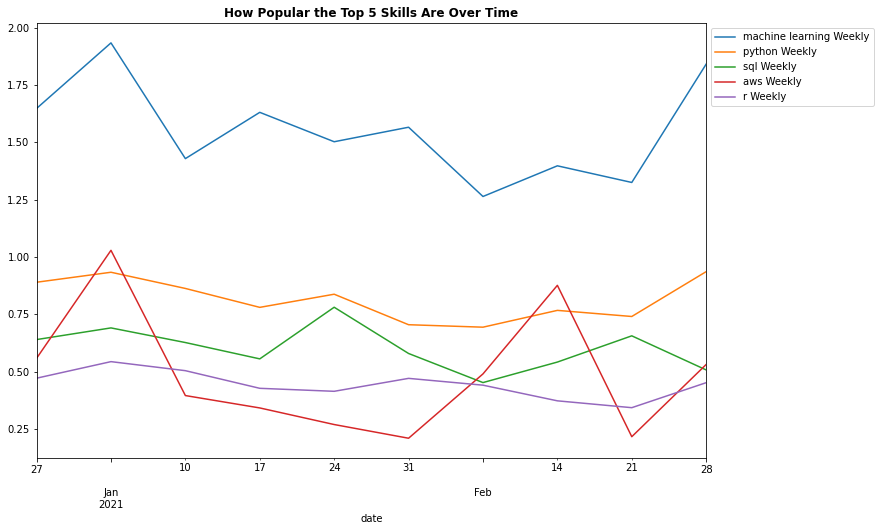

In [18]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_tech)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_tech)

In [19]:
# Create a soft skill library
ds_soft_library = ['critical thinking','communication','problem solving','teamwork','ethics','business acumen',
                'interpersonal skills','curiosity','storytelling','adaptability','team player','collaboration',
                'time management','leadership','domain knowledge','creativity','decision making',
                'verbal communication','written communication','teamwork']

In [20]:
# Print the number of skills in the library
print("Number of data science skills in soft skill library: ", len(ds_soft_library))

# Print the top 5 needed soft skills

ds_top_soft = MVP_explore.top_skills(df_ds, 5, ds_soft_library, 'soft')
ds_top_soft

Number of data science skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_soft_skills,frequency
0,communication,1647.0
1,leadership,1028.0
2,collaboration,490.0
3,problem solving,359.0
4,written communication,265.0


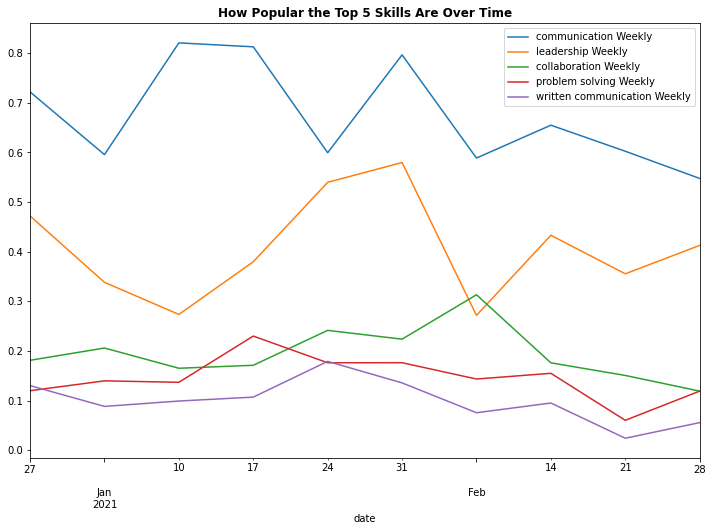

In [21]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_soft)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_soft)

In [22]:
# Create a general library
ds_general_library = ['python','sql','pandas','numpy','matplotlib','scikit learn','scikitlearn','spark','hadoop',
                'aws','amazon web services','azure','microsoft word', 'microsoft excel','excel','tableau',
                'tensor flow','pytorch','hive','impala','matlab','etl','statistics','exploration',
                'extraction','data wrangling','math','machine learning','data visualization','java','js',
                'javascript','scala','r','c','c++','power bi','dashboard','linear algebra','calculus',
                'neural networks','eda','big data','frameworks','database management','testing hypotheses',
                'probability','data mining','perl','nosql','saas','git','github','natural language processing',
                'nlp', 'deep learning','agile','kanban','project management','julia','devops','google cloud',
                'pytorch','computer vision', 'deep neural networks','neural networks','amazon web services',
                'natural language processing','extract,transform,load','mysql','structured query language'
                'critical thinking','communication','problem solving','teamwork','ethics','business acumen',
                'interpersonal skills','curiosity','storytelling','adaptability','team player','collaboration',
                'time management','leadership','domain knowledge','creativity','decision making',
                'verbal communication','written communication','teamwork']

In [23]:
# Print the number of skills in the library
print("Number of data science skills in general skills library: ", len(ds_general_library))

# Print the top 5 needed general skills

ds_top_general = MVP_explore.top_skills(df_ds, 5, ds_general_library, 'general')
ds_top_general

Number of data science skills in general skills library:  90
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_general_skills,frequency
0,machine learning,3703.0
1,python,1952.0
2,communication,1647.0
3,sql,1482.0
4,aws,1157.0


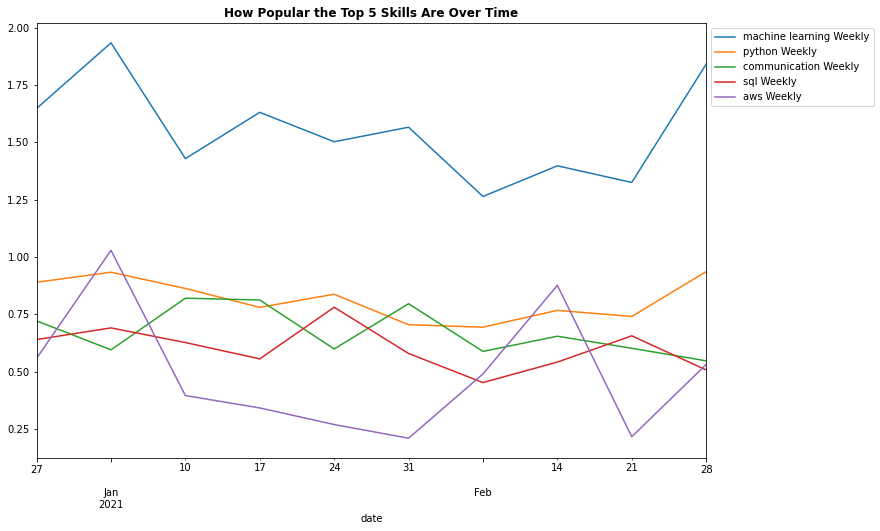

In [24]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_general)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_general)

#### Web Developer Position
- Tech skills
- Soft skills
- General Skills (Combination of Tech+Soft)

In [25]:
# Create a tech library
wd_tech_library = ['html','css','javascript','debugging','git','github','libraries','frameworks','publishing web site',
'photoshop','bootstrap','jquery','search engine optimization','seo','basic graphic design','front end','back end',
'visual studio code','visual studio','figma','zeplin','sketch','gatspy','strapi','paint','canva','aws','azure',
'amazon web services','sql','mysql','nosql','node','node.js','js','json','api','google charts','d3','d3.js','react',
'angular','ember','vue','python','c','c++','ruby','ruby on rails','git','github','php','net','.net','java','c#',
'linux','go','gcp','troubleshooting','problem solving','ux','ui','ux/ui','cloud computing','netlify','net']  

In [26]:
# Print the number of skills in the library
print("Number of web dev skills in tech skill library: ", len(wd_tech_library))

# Print the top 5 needed tech skills

wd_top_tech = MVP_explore.top_skills(df_wd, 5, wd_tech_library, 'tech')
wd_top_tech

Number of web dev skills in tech skill library:  67
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_tech_skills,frequency
0,javascript,3727.0
1,java,2506.0
2,sql,2280.0
3,react,1996.0
4,net,1863.0


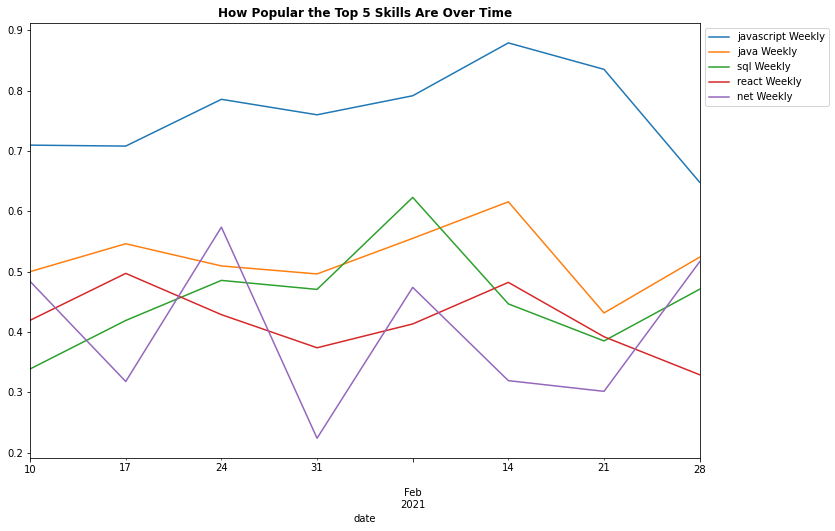

In [27]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_tech)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_tech)

In [28]:
# Create a soft library
wd_soft_library = ['critical thinking','communication','problem solving','teamwork','ethics','business acumen',
                'interpersonal skills','curiosity','storytelling','adaptability','team player','collaboration',
                'time management','leadership','domain knowledge','creativity','decision making',
                'verbal communication','written communication','teamwork']

In [29]:
# Print the number of skills in the library
print("Number of web dev skills in soft skill library: ", len(wd_soft_library))

# Print the top 5 needed soft skills

wd_top_soft = MVP_explore.top_skills(df_wd, 5, wd_soft_library, 'soft')
wd_top_soft

Number of web dev skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_soft_skills,frequency
0,communication,2739.0
1,leadership,1069.0
2,collaboration,708.0
3,problem solving,582.0
4,written communication,421.0


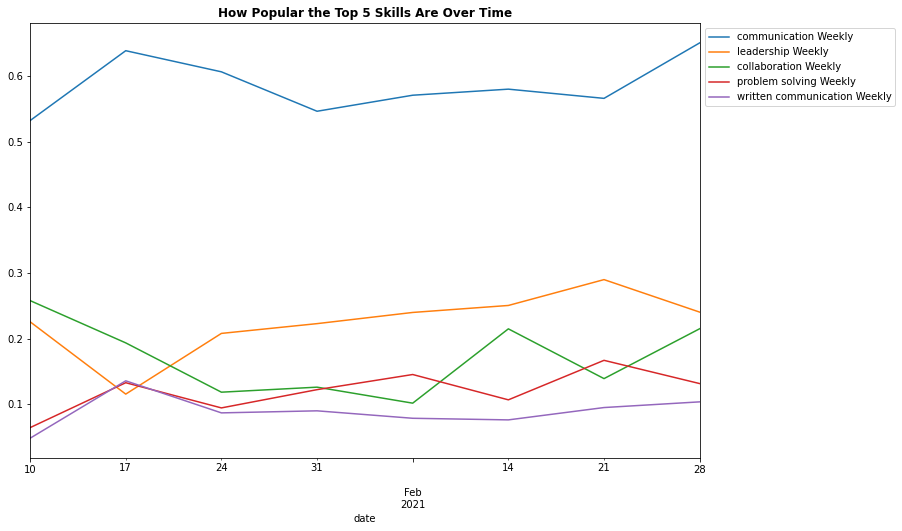

In [30]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_soft)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_soft)

In [31]:
# Create a general library
wd_general_library = ['html','css','javascript','debugging','git','github','libraries','frameworks','publishing web site',
'photoshop','bootstrap','jquery','search engine optimization','seo','basic graphic design','front end','back end',
'visual studio code','visual studio','figma','zeplin','sketch','gatspy','strapi','paint','canva','aws','azure',
'amazon web services','sql','mysql','nosql','node','node.js','js','json','api','google charts','d3','d3.js','react',
'angular','ember','vue','python','c','c++','ruby','ruby on rails','git','github','php','net','.net','java','c#',
'linux','go','gcp','troubleshooting','problem solving','ux','ui','ux/ui','cloud computing','netlify','net''critical thinking',
'communication','problem solving','teamwork','ethics','business acumen','interpersonal skills','curiosity',
'storytelling','adaptability','team player','collaboration','time management','leadership','domain knowledge',
'creativity','decision making','verbal communication','written communication','teamwork']

In [32]:
# Print the number of skills in the library
print("Number of web dev skills in general skill library: ", len(wd_general_library))

# Print the top 5 needed general skills

wd_top_general = MVP_explore.top_skills(df_wd, 5, wd_general_library, 'general')
wd_top_general

Number of web dev skills in general skill library:  86
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_general_skills,frequency
0,javascript,3727.0
1,communication,2739.0
2,java,2506.0
3,sql,2280.0
4,react,1996.0


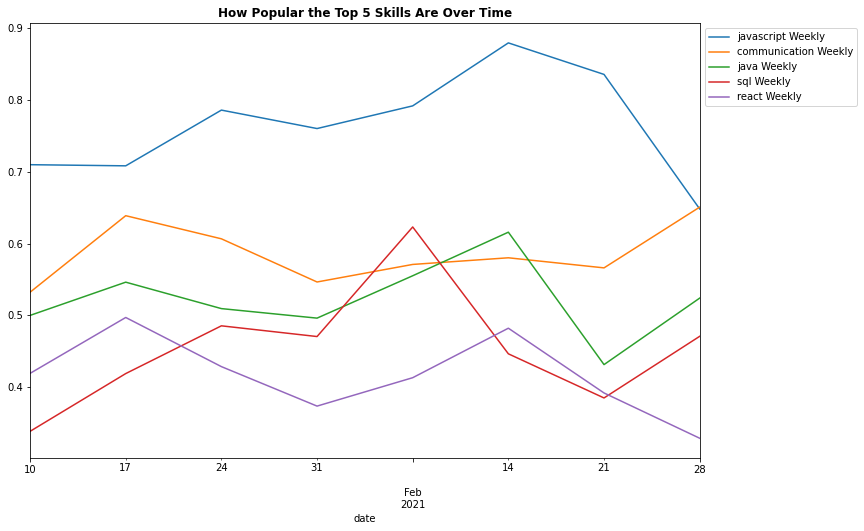

In [33]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_general)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_general)